# Building a Numerical Solution of a Hyperbolic System from Riemann Problem

Recall that for the finite volume scheme, we are keeping track (i.e. actually calculating and storing) average values of the function around a grid point. 

But the end of the day we are only keeping one value per grid point (as in the finite difference scheme).

But note that between each grid cell (i.e. at half integer indices (e.g. at index $i+\frac{1}{2}$)) there is a discontinuous jump between two states.

Idea (by Godunov 1959): solve the Riemann problem for every discontinuity at each grid point interface. Then piece together all the local solutions to get the global solution.

Recall that we sort of cheated last lecture by linearising a possibly nonlinear PDE. I.e. we went from:

$\frac{\partial U}{\partial t}+\frac{\partial F}{\partial x}=0$ where $F=F(U)$

to 

$\frac{\partial U}{\partial t}+ A \frac{\partial U}{\partial x}=0$

where $A$ depended information of some reference state and was __constant__. 

and the solution to this linearised hyperbolic PDE is we get a Riemann fan eminating from the discontinuity traveling along the characteristics which had the speed of the eigenvalues of the matrix. These eigenvalues are, of course, a function of the reference state at the beginning of the time step.

Here's a little diagram

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(-0.5, 783.5, 373.5, -0.5)

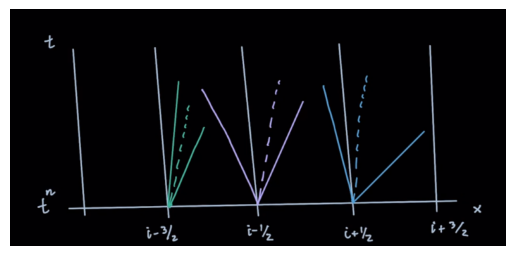

In [2]:
image=mpimg.imread('Fan 12.png')
plt.imshow(image)
plt.axis('off')

Notice that the characteristic speeds are different at each grid point, as they depend on matrix A which are a function of local primitive reference variables.

Intuitively there should be some limit on the time step as well.

Recall that for the linear advection equation we needed a time step such that the information would not propogate more than one cell. Hence we get:

$\delta t < \frac{\delta x}{|\lambda_{max}|}$

Recall as well that the $\lambda$'s are of unit speed.

So in essence we DON'T want the information to travel more than one step!

Recall that this whole thing started when talking about the finite volume scheme, which was obtained via integrating the conservative PDE, and got out an expression essentially saying that the values within grid cells only changed via fluxes through the grid interfaces.

The expression was this:

$<U_i>^{n+1}=<U_i>^n-\frac{\delta t}{\delta x}(F^{n+\frac{1}{2}}_{i+\frac{1}{2}}-F^{n+\frac{1}{2}}_{i-\frac{1}{2}})$

where 
$\tilde{F}^{n+\frac{1}{2}}_{i\pm \frac{1}{2}}=\frac{1}{\delta t}\int^{t_{n+1}}_{t_n}F(U(x_{i\pm \frac{1}{2}},t))dt$

the theory behind the riemann fan will help us get the fluxes through each boundary!

Recall that locally and with our linearisation, we essentially get a linear advection equation.

To compute the flux that is happening at the interface we must combine the stuff that's coming in from the left (which recall are just being translated to the right) and the stuff that's coming in from the right, which all travel along local characteristics

Let's consider the 1D Euler problem with the following initia condition.

$U_L=\begin{bmatrix}\rho_L \\ v_{xL} \\ P_L \end{bmatrix}$ 

$U_R = \begin{bmatrix} \rho_R \\ v_{xR} \\ P_R \end{bmatrix}$

We have a discontinuity, which can be composed as a linear combination of the right eigenvectors (of the matrix A).

Recall that the left eigenvectors form a dual basis (they can be represented by row vectors) with the right eigenvectors, and thus equal the Kronecker delta when multiplied with the right eigenvectors. Thus we can find the eigenweights (i.e. the coefficients of the right eigenvectors) by multiplying the discontinuity by the left eigenvectors.

She goes through the calculation explicitly at around 26:00.

Recall then that when we plug this into our linearised Euler equation, we get the linear advection equation for each component in the eigenbasis.

(i.e. we get $\partial_tw_i+\lambda_i\partial_xw_i=0$)

So how do we get the flux through the interface in order to apply this to our finite volume scheme? (i.e. how do we get the $\tilde{F}^{n+\frac{1}{2}}_{i+\frac{1}{2}}$ and the $\tilde{F}^{n+\frac{1}{2}}_{i-\frac{1}{2}}$)

What we need to find the flux at the boundaries are the mixed state U i.e.

$U_{mixed state}=U^{m_0} = \begin{cases} U_L & \text{if } \frac{x}{t}<\lambda^1 \text{i.e. smaller than smallest eigenvalue}\\ U_L+\sum^{m_0}_{p=1}w^pr^p & \text{if in between}\\ U_R & \text{if } \frac{x}{t} \geq \lambda^m \text{i.e. greater than largest eigenvalue}\end{cases}$

But this gives us U! How do we get the flux?

Let's go back to our nonlinearised PDE and compare it to our linearised PDE. If we compare terms we can think of $F=AU$

Now if else statements are notoriously slow in programming, and so we would like to find a way to do this without using them.

Let's define some auxilliary variables. 

$\lambda^{+,m}=max(\lambda^m,0)$ 

which picks out right-moving characteristics.

$\lambda^{-,m}=min(\lambda^m,0)$

which picks out left moving characteristics.

$F_L=AU_L$

$F_R=AU_R$

So if we consider the first penultimate left state we get

$U_1=U_L+w_1r_2$ 

to get to our flux we get:

$F_{interface}=AU_1=AU_L + Aw_1r_1=F_L + \lambda_1 w_1 r_1$
...

Note that the interface always lies to the right of the last negative eigenvalue. We can reexpress the flux as:

$F_{interface} = F_L + \sum^3_{m=1}\lambda^{-,m}w_mr_m$

Let's start from the right side. This time we get:

$U_1=U_R-w_3r_3-w_2r_2$

so we get:

$F_{interface}=F_R-\sum^3_{m=1}\lambda^{+,m}w_mr_m$

So now we have two equivalent expressions for the flux. Let's take an average so we get:

$F_{interface}=\frac{1}{2}(F_L+F_R)-\frac{1}{2}(|\lambda_1|w_1r_1-|\lambda_2|w_2r_2+|\lambda_3|w_3r_3)$

Recall that we have found $F$ but we actually want to find $\tilde{F}^{n+\frac{1}{2}}_{i\pm \frac{1}{2}}$

which is this relation:

$\tilde{F}^{n+\frac{1}{2}}_{i\pm \frac{1}{2}}=\frac{1}{\delta t}\int^{t_{n+1}}_{t_n}F(U(x_{i\pm \frac{1}{2}},t))dt$

Since our grid cell is so small, we can approximate the expression inside the integral as constant and pull it out. Now the integral just evaluates to $\delta t$.

this is the __1st order Riemann Scheme__

We've been using the Euler Equations, but this is applicable to all hyperbolic PDEs!

for example, isothermal turbulence (where there is no energy flow so is thus 2 dimensional in phase space in 1 dimension of space).

We can also do magnetohydrodynamics which has 7 characteristics. If we have many characteristics, it is possible to make an approximation by just following the right-most or left-most waves. This is called the __HLL__ scheme. 

Note we want 3 things from numerical methods:
1. Efficiency
2. Accuracy
3. Stability

often there is a tradeoff between accuracy and stability

Another advantage of finite volume schemes is that we do not need a uniform grid. It is possible then to have the mesh adapt to the specific problem!